<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Proyecto de grado 2</h4>
<h4 style="text-align: center;">Tarea: Fase 1</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andrés Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia – UNAD</h4>
<h4 style="text-align: center;">Fecha: Abril de 2025</h4>


In [987]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

## Conectar datos

In [988]:
import urllib
from sqlalchemy import create_engine
import pandas as pd
columns_to_check = ['price', 'habitaciones', 'banyos', 'estrato', 'areaConstruida',
                        'areaPrivada', 'parqueaderos', 'administracion', 'pisoNumero', 'totalPisos']

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=asdf1234;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a través de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [989]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

            price  habitaciones  \
0    120000000.00          2.00   
1    105000000.00          1.00   
2   7850000000.00          1.00   
3  22000000000.00          1.00   
4 107158800000.00           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogotá - Germania   
2  Edificio en venta, Bogotá - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...    1.00  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...    2.00  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   es

# Exploración preliminar

## Caracterización general de la muestra 

In [990]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,12626.00,11551.00,11884.00,12479.00,12541.00,11561.00,8163.00,7508.00,9906.00,9319.00
mean,18526799529.32,2.85,2.57,4.04,149.26,119.14,2.35,3097791.43,3.50,1.24
std,860106309561.06,4.31,1.98,1.32,171.12,165.71,3.32,43218820.61,4.08,2.86
min,1000.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00,0.00,0.00
25%,256325000.00,2.00,1.00,3.00,52.00,30.00,1.00,144627.50,0.00,0.00
50%,484000000.00,3.00,2.00,4.00,81.00,64.00,2.00,333600.00,2.00,0.00
75%,1100000000.00,3.00,3.00,5.00,172.00,134.00,2.00,730000.00,5.00,0.00
max,95000000000000.00,400.00,60.00,7.00,998.00,998.00,127.00,2000000000.00,21.00,21.00


## Calidad de la información

In [991]:
df_nuevo = df
def discrete_variable_summary(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    columnas_a_excluir = [col for col in excluir if col in df.columns]
    df_resultado = df.drop(columns=columnas_a_excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        # Nulos
        nulos = df[column].isna().sum()
        
        # Moda considerando nulos
        if nulos > freq:
            moda_nulos = np.nan
            freq_nulos = nulos
        else:
            moda_nulos = moda
            freq_nulos = freq
        
        perc_nulos = (freq_nulos / total) * 100 if total > 0 else 0

        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2),
            'mode_nulos': moda_nulos,
            'freq_nulos': freq_nulos,
            'perc_nulos': round(perc_nulos, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)


discrete_variable_summary(df_nuevo)

,col,uniques,mode,freq,perc,mode_nulos,freq_nulos,perc_nulos
0,price,1932,450000000.00,140,1.11,450000000.00,140,1.11
1,habitaciones,29,3.00,4936,42.73,3.00,4936,39.09
2,descr,1122,Apartamento en Venta,5389,42.68,Apartamento en Venta,5389,42.68
3,link,12626,https://www.fincaraiz.com.co/apartaestudio-en-...,1,0.01,https://www.fincaraiz.com.co/apartaestudio-en-...,1,0.01
4,banyos,24,2.00,4378,36.84,2.00,4378,34.67
5,id,12626,2351795,1,0.01,2351795,1,0.01
6,tipoInmueble,15,Apartamento,7840,62.19,Apartamento,7840,62.09
7,estadoInmueble,6,¡Pregúntale!,11666,92.54,¡Pregúntale!,11666,92.40
8,areaConstruida,1275,60.00,181,1.44,60.00,181,1.43
9,areaPrivada,1115,0.00,2158,18.67,0.00,2158,17.09


## Distribución de los datos

In [992]:
print(df_nuevo["antiguedad"].unique())
# Diccionario de codificación
map_antiguedad = {
    "menor a 1 año": 0,
    "1 a 8 años": 1,
    "9 a 15 años": 2,
    "16 a 30 años": 3,
    "más de 30 años": 4,
    "¡Pregúntale!": None
}

# Reemplazar valores vacíos por NaN
df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace('', np.nan)

# Aplicar codificación
df_nuevo["antiguedad_encoded"] = df_nuevo["antiguedad"].map(map_antiguedad)

# Imputar valores faltantes con la moda
moda = df_nuevo["antiguedad_encoded"].mode()[0]
df_nuevo["antiguedad_encoded"].fillna(moda, inplace=True)

# Asegúrate de que la columna esté en tipo numérico
print(df_nuevo["antiguedad_encoded"].unique())



['9 a 15 años' 'menor a 1 año' '16 a 30 años' '¡Pregúntale!' '1 a 8 años'
 'más de 30 años' '']
[2. 0. 3. 1. 4.]


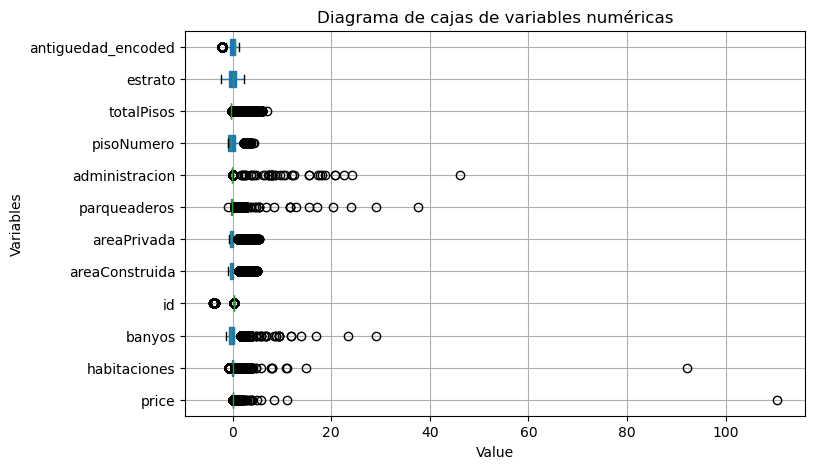

In [993]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Numérica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categórica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Numérica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Diagrama de cajas de variables numéricas')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df_nuevo)

## Relaciones entre variables numéricas

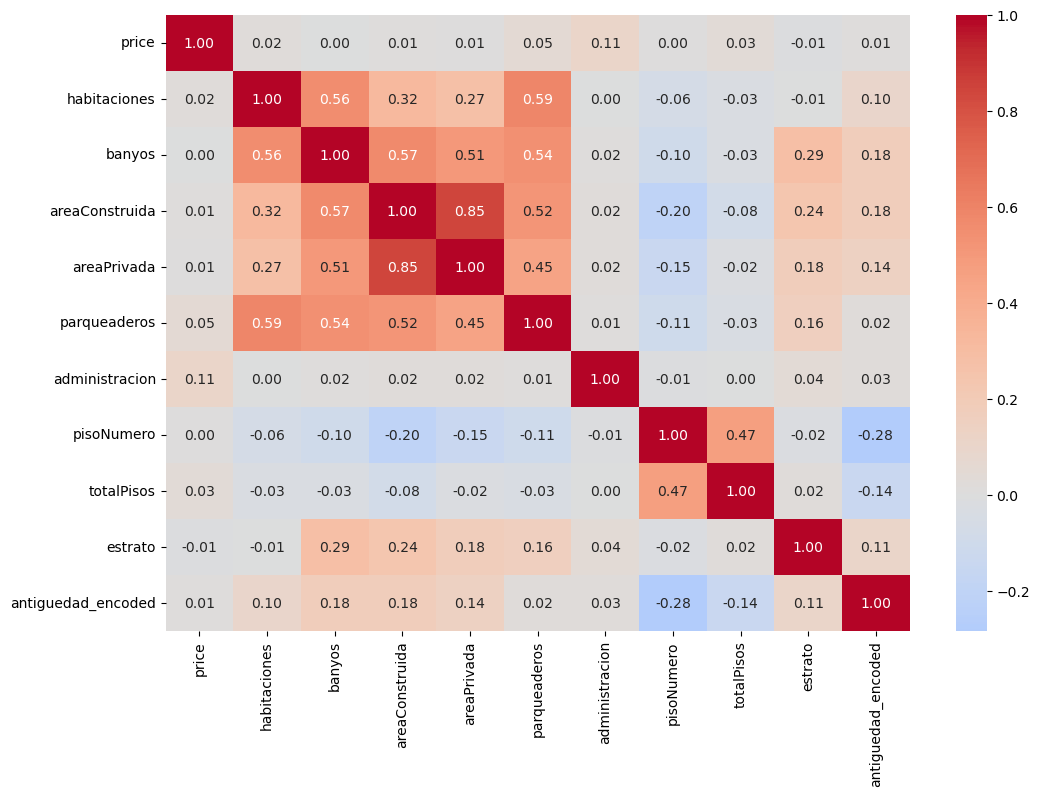

In [994]:
numerics = [num for num in df_nuevo.columns if clasificar_variable(df_nuevo[num].dtype)=='Numérica' and num!="id"]

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df_nuevo[numerics])

# Limpieza de datos

In [995]:
trash_columns = ['descr', 'link','id','date_modified','date_created']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12626 entries, 0 to 12625
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               12626 non-null  float64
 1   habitaciones        11551 non-null  float64
 2   banyos              11884 non-null  float64
 3   tipoInmueble        12606 non-null  object 
 4   estadoInmueble      12606 non-null  object 
 5   areaConstruida      12541 non-null  float64
 6   areaPrivada         11561 non-null  float64
 7   antiguedad          12606 non-null  object 
 8   parqueaderos        8163 non-null   float64
 9   administracion      7508 non-null   float64
 10  pisoNumero          9906 non-null   float64
 11  totalPisos          9319 non-null   float64
 12  comodidades         10719 non-null  object 
 13  ubicacion           12626 non-null  object 
 14  estrato             12479 non-null  float64
 15  antiguedad_encoded  12626 non-null  float64
dtypes: f

In [996]:
print(f"records before cleaning dataframe: {df_nuevo.count()}")
def clean_dataframe(df_):
    # Remove rows with negative values, ignoring NaNs
    for col in columns_to_check:
        df_ = df_[(df_[col] >= 0) | (df_[col].isnull())]

    print(f"Total rows after removing negatives: {df_.shape[0]}")

    # Remove rows where 'estrato' is greater than 6, ignoring NaNs
    df_ = df_[(df_['estrato'] <= 6) | (df_['estrato'].isnull())]

    df_['estadoInmueble'] = df_['estadoInmueble'].replace('¡Pregúntale!', np.nan)
    # Reset the DataFrame index
    df_.reset_index(drop=True, inplace=True)

    return df_

df_cleaned=clean_dataframe(df_nuevo)
print(f"records after cleaning dataframe: {df_cleaned.count()}")

records before cleaning dataframe: price                 12626
habitaciones          11551
banyos                11884
tipoInmueble          12606
estadoInmueble        12606
areaConstruida        12541
areaPrivada           11561
antiguedad            12606
parqueaderos           8163
administracion         7508
pisoNumero             9906
totalPisos             9319
comodidades           10719
ubicacion             12626
estrato               12479
antiguedad_encoded    12626
dtype: int64
Total rows after removing negatives: 12625
records after cleaning dataframe: price                 12618
habitaciones          11547
banyos                11880
tipoInmueble          12598
estadoInmueble          940
areaConstruida        12534
areaPrivada           11557
antiguedad            12598
parqueaderos           8161
administracion         7508
pisoNumero             9903
totalPisos             9316
comodidades           10715
ubicacion             12618
estrato               12471
antigue

In [997]:
df_cleaned.isnull().sum()

price                     0
habitaciones           1071
banyos                  738
tipoInmueble             20
estadoInmueble        11678
areaConstruida           84
areaPrivada            1061
antiguedad               20
parqueaderos           4457
administracion         5110
pisoNumero             2715
totalPisos             3302
comodidades            1903
ubicacion                 0
estrato                 147
antiguedad_encoded        0
dtype: int64

In [998]:
(df_cleaned == 0).sum()

price                    0
habitaciones           660
banyos                 260
tipoInmueble             0
estadoInmueble           0
areaConstruida          14
areaPrivada           2156
antiguedad               0
parqueaderos             0
administracion         693
pisoNumero            3262
totalPisos            7021
comodidades              0
ubicacion                0
estrato                  0
antiguedad_encoded     461
dtype: int64

In [999]:
df_cleaned = df_cleaned.drop("pisoNumero", axis=1)
df_cleaned = df_cleaned.drop("totalPisos", axis=1)

In [1000]:
#df_cleaned["estrato"] =df_cleaned["estrato"].replace(0, np.nan)
#df_cleaned["areaConstruida"] =df_cleaned["areaConstruida"].replace(0, np.nan)
#df_cleaned["areaPrivada"] =df_cleaned["areaPrivada"].replace(0, np.nan)
#df_cleaned["administracion"] =df_cleaned["administracion"].replace(0, np.nan)
#df_cleaned["banyos"] =df_cleaned["banyos"].replace(0, np.nan)
#df_cleaned["habitaciones"] =df_cleaned["habitaciones"].replace(0, np.nan)

df_cleaned = df_cleaned[df_cleaned['estrato'] != 0] 
df_cleaned = df_cleaned[df_cleaned['areaConstruida'] != 0] 
df_cleaned = df_cleaned[df_cleaned['areaPrivada'] != 0] 
df_cleaned = df_cleaned[df_cleaned['administracion'] != 0] 
df_cleaned = df_cleaned[df_cleaned['banyos'] != 0] 
df_cleaned = df_cleaned[df_cleaned['habitaciones'] != 0]

In [1001]:
df_cleaned["estadoInmueble"].unique()

array(['Excelenteestado', 'Buenestado', nan, None, 'Reciclada', 'Nuevo',
       'Requieremantenimiento'], dtype=object)

In [1002]:
df_cleaned["administracion"] = df_cleaned["administracion"].fillna(0)
df_cleaned["parqueaderos"] = df_cleaned["parqueaderos"].fillna(0)
df_cleaned["habitaciones"] = df_cleaned["habitaciones"].fillna(0)
#df_cleaned["pisoNumero"] = df_cleaned["pisoNumero"].fillna(df_cleaned["pisoNumero"].median())
#df_cleaned["totalPisos"] = df_cleaned["totalPisos"].fillna(df_cleaned["banyos"].median())
df_cleaned["banyos"] = df_cleaned["banyos"].fillna(0)
df_cleaned["comodidades"] = df_cleaned["comodidades"].fillna("")
df_cleaned["estadoInmueble"] = df_cleaned["estadoInmueble"].fillna("No especificado")
df_cleaned = df_cleaned[df_cleaned['areaPrivada'] > 0] # "No especificado"
df_cleaned = df_cleaned.dropna()

In [1003]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series, factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor.
    If Q1 == Q3 == 0, applies a log1p transformation to spread the distribution first.
    """
    print(series.name)
    valid = series.dropna()

    # If series is empty or all identical values
    if valid.nunique() <= 1:
        return (-np.inf, np.inf)

    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)

    # Check for flat IQR caused by extreme skew or zero dominance
    if Q1 == 0 and Q3 == 0:
        print(f"Column: {series.name} has Q1 = Q3 = 0, applying log1p transform")
        valid = np.log1p(valid)
        Q1 = valid.quantile(0.25)
        Q3 = valid.quantile(0.75)

    IQR = Q3 - Q1
    mean_val = valid.mean()
    median_val = valid.median()

    # Fallback if median <= 0 or IQR is too small
    if median_val <= 0 or np.isnan(mean_val) or IQR == 0:
        std = valid.std()
        mean_val = valid.mean()
        if np.isnan(std) or std == 0:
            return (-np.inf, np.inf)  # can't calculate anything useful
        print(f"Column: {series.name} — Using mean ± {factor} × std as fallback")
        return (mean_val - factor * std, mean_val + factor * std)

    log_skew_factor = (mean_val / median_val) ** 0.66
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}, IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

    subs_left = factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else factor * IQR
    add_right = factor * IQR * log_skew_factor
    lower_bound = Q1 - subs_left
    upper_bound = Q3 + add_right
    print(f"column: {series.name}, lower bound is {lower_bound:.3f}, upper bound is {upper_bound:.3f}, "
          f"subs left: {subs_left:.3f}, add right: {add_right:.3f}")
    return lower_bound, upper_bound


def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df_cleaned, factor=4.0)

price
Column: price, log skew factor: 13.306, mean: 22966916877.3, median: 455000000.0, IQR: 744050000.000, Q1: 245950000.000, Q3: 990000000.000
column: price, lower bound is 22272730.217, upper bound is 40590655214.517, subs left: 223677269.783, add right: 39600655214.517
habitaciones
Column: habitaciones, log skew factor: 0.946, mean: 2.8, median: 3.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: habitaciones, lower bound is -2.228, upper bound is 6.784, subs left: 4.228, add right: 3.784
banyos
Column: banyos, log skew factor: 1.152, mean: 2.5, median: 2.0, IQR: 2.000, Q1: 1.000, Q3: 3.000
column: banyos, lower bound is -5.944, upper bound is 12.216, subs left: 6.944, add right: 9.216
areaConstruida
Column: areaConstruida, log skew factor: 1.483, mean: 145.3, median: 80.0, IQR: 116.000, Q1: 50.000, Q3: 166.000
column: areaConstruida, lower bound is -262.885, upper bound is 854.100, subs left: 312.885, add right: 688.100
areaPrivada
Column: areaPrivada, log skew factor: 1.494, mean: 143.

# Análisis descriptivo post-limpieza

## Caracterización general de la muestra

In [1004]:
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion"]
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion
count,7603.00,7603.00,7603.00,7603.00,7603.00,7603.00,7603.00,7603.00
mean,1416392839.38,2.49,2.29,4.00,125.14,123.39,1.33,377822.11
std,3729535848.42,1.22,1.49,1.32,132.67,134.14,1.78,605328.58
min,23000000.00,0.00,0.00,1.00,0.10,1.00,0.00,0.00
25%,242700000.00,2.00,1.00,3.00,50.00,48.00,0.00,0.00
50%,439000000.00,3.00,2.00,4.00,76.00,74.00,1.00,160000.00
75%,870000000.00,3.00,3.00,5.00,144.50,140.00,2.00,500000.00
max,40000000000.00,6.00,12.00,6.00,830.00,818.00,11.00,7200000.00


* La mayoría de los inmuebles registrados corresponden a apartamentos con entre 2 y 3 habitaciones y 2 baños, configuraciones que reflejan un mercado dirigido principalmente a viviendas familiares o de gama media, en línea con la estructura típica del mercado inmobiliario de Bogotá.
* 	Las variables físicas, como habitaciones, baños y parqueaderos, tienden a concentrarse en valores bajos o medios, siendo comunes los inmuebles con 1 parqueadero y ubicados en edificios de hasta 2 pisos
* Á	áreaConstruida y áreaPrivada mantienen una relación directa y elevada, lo cual es consistente con la naturaleza propia de estas variables, donde el área privada constituye una proporción significativa del área construid
* L• La variable estrato presenta una moda en el valor 3 y seis categorías distintas, lo que concuerda con la segmentación oficial de estratos socioeconómicos en Bogotá y su distribución en la oferta inmobiliaria de la ciudd.


## Calidad de la información

In [1048]:
def discrete_variable_summary_without_nulls(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    columnas_a_excluir = [col for col in excluir if col in df.columns]
    df_resultado = df.drop(columns=columnas_a_excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        
        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)

discrete_variable_summary_without_nulls(df_no_outliers)

,col,uniques,mode,freq,perc
0,price,1264,450000000.00,85,1.12
1,habitaciones,7,3.00,3299,43.39
2,banyos,12,2.00,2813,37.00
3,tipoInmueble,14,Apartamento,5089,66.93
4,estadoInmueble,6,No especificado,6920,91.02
5,areaConstruida,871,72.00,121,1.59
6,areaPrivada,889,50.00,127,1.67
7,antiguedad,6,16 a 30 años,2257,29.69
8,parqueaderos,12,0.00,2621,34.47
9,administracion,1478,0.00,2771,36.45


* La variable estadoInmueble presenta cerca del 90% de registros sin información, luego de sustituir el placeholder ¡Pregúntale! por valores nulos. Esto sugiere que es una característica que frecuentemente no es diligenciada durante el registro de los inmuebles.
* 	Variables como areaPrivada y administracion muestran que, al incluir los nulos, estos se convierten en la moda, evidenciando una falta sistemática de información o baja prioridad en su registro
* •	Otras variables, como parqueaderos y pisoNumero, también presentan porcentajes considerables de valores nulos, posiblemente asociados a características no siempre presentes o consideradas en ciertos tipos de inmueble.


## Distribución de los datos

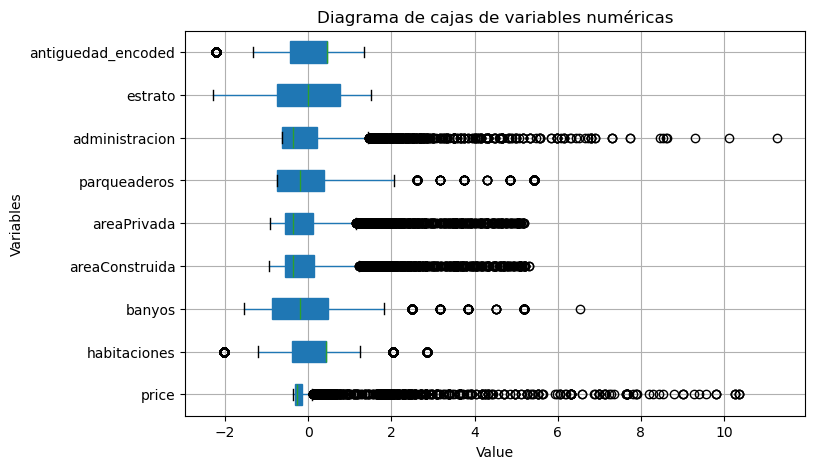

In [1006]:
create_box(df_no_outliers)

* Variables como administración, áreaConstruida, áreaPrivada y price presentan numerosos valores atípicos, lo que sugiere una alta variabilidad en estas características y posibles registros con errores o inmuebles significativamente diferentes al promedio.
* Por el contrario, variables como estrato, totalPisos, baños, habitaciones y parqueaderos muestran distribuciones relativamente simétricas, lo que refleja consistencia en los datos recopilados. Sin embargo, variables como administración, áreaConstruida, áreaPrivada y, especialmente, price, exhiben una mayor dispersión, indicando una oferta diversa en cuanto a características físicas y precios de los inmuebles.

## Principales hallazgos de correlación

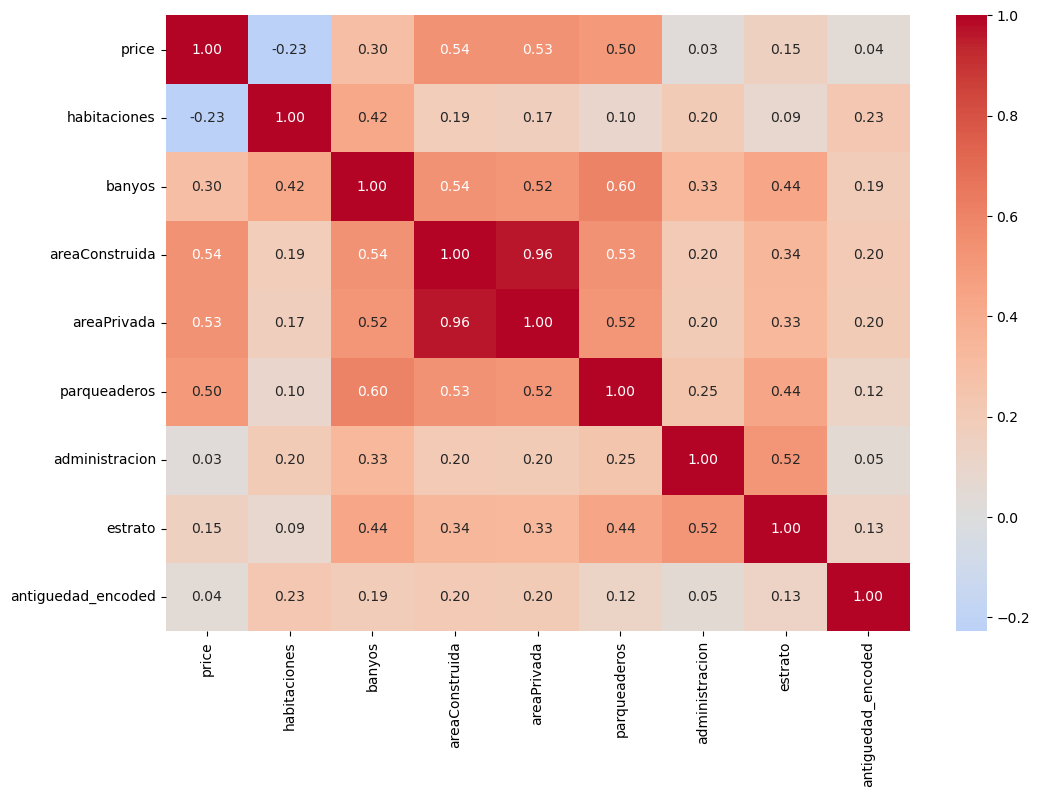

In [1007]:
numerics = [num for num in df_no_outliers.columns if clasificar_variable(df_no_outliers[num].dtype)=='Numérica']
corr_matrix(df_no_outliers[numerics])

* Se observa una correlación fuerte entre administracion, areaConstruida, parqueaderos y baños con price, lo que sugiere que las dimensiones y equipamiento físico de las propiedades tienen un impacto significativo en su valor.
* 	Aunque estrato muestra una relación moderada con la cuota de administración y algunas características físicas como el número de baños, su relación directa con el precio es débil. Este comportamiento es consistente con la dinámica inmobiliaria de Bogotá, donde es común encontrar inmuebles de alto valor tanto en estratos medios como en estratos altos, debido a la influencia de factores como ubicación, estado de conservación o características adicionales
* •	Finalmente, variables como pisoNumero, totalPisos y habitaciones presentan una influencia reducida sobre el precio, indicando que no son determinantes relevantes en la variabilidad del valor de los inmuebles en la muestra analizad.


## limpieza de datos

In [1008]:
mapa_antiguedad = {
    "menor a 1 año": 1,
    "1 a 8 años": 2,
    "9 a 15 años": 3,
    "16 a 30 años": 4,
    "más de 30 años": 5,
    "¡Pregúntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

,price,habitaciones,banyos,tipoInmueble,estadoInmueble,areaConstruida,areaPrivada,antiguedad,parqueaderos,administracion,pisoNumero,totalPisos,comodidades,ubicacion,estrato,antiguedad_encoded
12434,700000000.00,3.00,2.00,Apartamento,¡Pregúntale!,126.00,0.00,2.00,2.00,320000.00,0.00,0.00,•Balcón•Chimenea•Closet•Duplex•PentHouse•Piso ...,"Modelia, Bogotá, Bogotá, d.c.",4.00,1.00
7806,530000000.00,6.00,4.00,Casa,¡Pregúntale!,255.60,255.60,4.00,1.00,NaN,0.00,0.00,•Calentador•Colegios / Universidades•Depósito ...,"Rincon de suba, Bogotá, Bogotá, d.c.",2.00,3.00
716,15000000000.00,1.00,1.00,Bodega,¡Pregúntale!,530.00,530.00,5.00,NaN,NaN,NaN,NaN,•Cerca centro comercial•Cocina Integral•Instal...,"Comuneros, Bogotá, Bogotá, d.c.",3.00,4.00
7169,780000000.00,3.00,3.00,Apartamento,¡Pregúntale!,122.00,119.00,2.00,2.00,600000.00,0.00,0.00,•Ascensor•Balcón•Baño Auxiliar•Calentador•Canc...,"San rafael, Bogotá, d.c.",5.00,1.00
132,115000000.00,2.00,1.00,Apartamento,Excelenteestado,47.00,47.00,3.00,NaN,70000.00,5.00,NaN,•Balcón•Circuito cerrado de TV•Cocina tipo Ame...,"Bosa San Bernardino, Bogotá, Bogotá, d.c.",2.00,2.00


In [1009]:
# Reemplazar NaN con cadena vacía para evitar problemas
df_no_outliers['comodidades'] = df_no_outliers['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_no_outliers['comodidades'].str.get_dummies(sep='•')

# Unir al DataFrame original
df_final = df_no_outliers.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

Index(['price', 'habitaciones', 'banyos', 'tipoInmueble', 'estadoInmueble',
       'areaConstruida', 'areaPrivada', 'antiguedad', 'parqueaderos',
       'administracion',
       ...
       'Zona Industrial', 'Zona Infantil', 'Zona Residencial', 'Zona de BBQ',
       'Zona de Camping', 'Zona de lavandería', 'Zonas Verdes',
       'Árboles frutales', 'Área Rural', 'Área Urbana'],
      dtype='object', length=198)

In [1010]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Reemplazar cadenas vacías
df_final = df_final.replace('', np.nan)

# Seleccionar solo columnas numéricas
#numeric_cols = df_final.select_dtypes(include=['int64', 'float64']).columns

# Escalar solo esas columnas
#scaler = StandardScaler()
#df_scaled = df_final.copy()
#df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Ver muestra
#df_scaled.sample(5)

In [1011]:
dummy_columns =["tipoInmueble", "estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_final,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

Index(['price', 'habitaciones', 'banyos', 'areaConstruida', 'areaPrivada',
       'antiguedad', 'parqueaderos', 'administracion', 'estrato',
       'antiguedad_encoded',
       ...
       'ubicacion_Zarzamora, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona Noroccidente, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona centro, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona chapinero, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona franca, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona industrial cazuca, Bogotá, Cundinamarca',
       'ubicacion_Zona industrial, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona norte, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona occidental, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona sur, Bogotá, Bogotá, d.c.'],
      dtype='object', length=1030)

In [1012]:
# Show count and percentage of nulls per column
nulls = df_encoded.isnull().sum().to_frame(name='null_count')
nulls['null_percentage'] = 100 * nulls['null_count'] / len(df)

print(nulls[nulls['null_count']>0])

Empty DataFrame
Columns: [null_count, null_percentage]
Index: []


In [1013]:

#df_encoded["banyos"] = df_encoded["banyos"].fillna(0)
#df_encoded["areaConstruida"] = df_encoded["areaConstruida"].fillna(df_encoded["areaConstruida"].median())
#df_encoded["pisoNumero"] = df_encoded["pisoNumero"].fillna(df_encoded["pisoNumero"].median())
#df_encoded["areaPrivada"] = df_encoded["areaPrivada"].fillna(df_encoded["areaPrivada"].median())
#df_encoded["totalPisos"] = df_encoded["totalPisos"].fillna(df_encoded["totalPisos"].median())
#df_encoded["estrato"] = df_encoded["estrato"].fillna(df_encoded["estrato"].median())

# df_encoded = df_encoded.dropna()

# 1. Definir etiquetas
# etiquetas = [1,2,3,4,5,6,7]

# # 2. Calcular los límites (min y max del price)
# min_price = df_encoded['price'].min()
# max_price = df_encoded['price'].max()

# # 3. Generar los bins (límites de categoría)
# bins = np.linspace(min_price, max_price, num=len(etiquetas)+1)

# # 4. Crear nueva columna categórica
# df_encoded['range_price'] = pd.cut(df_encoded['price'], bins=bins, labels=etiquetas, include_lowest=True)

if "antiguedad" in df_encoded.columns:
    df_encoded=df_encoded.drop(columns=["antiguedad"])


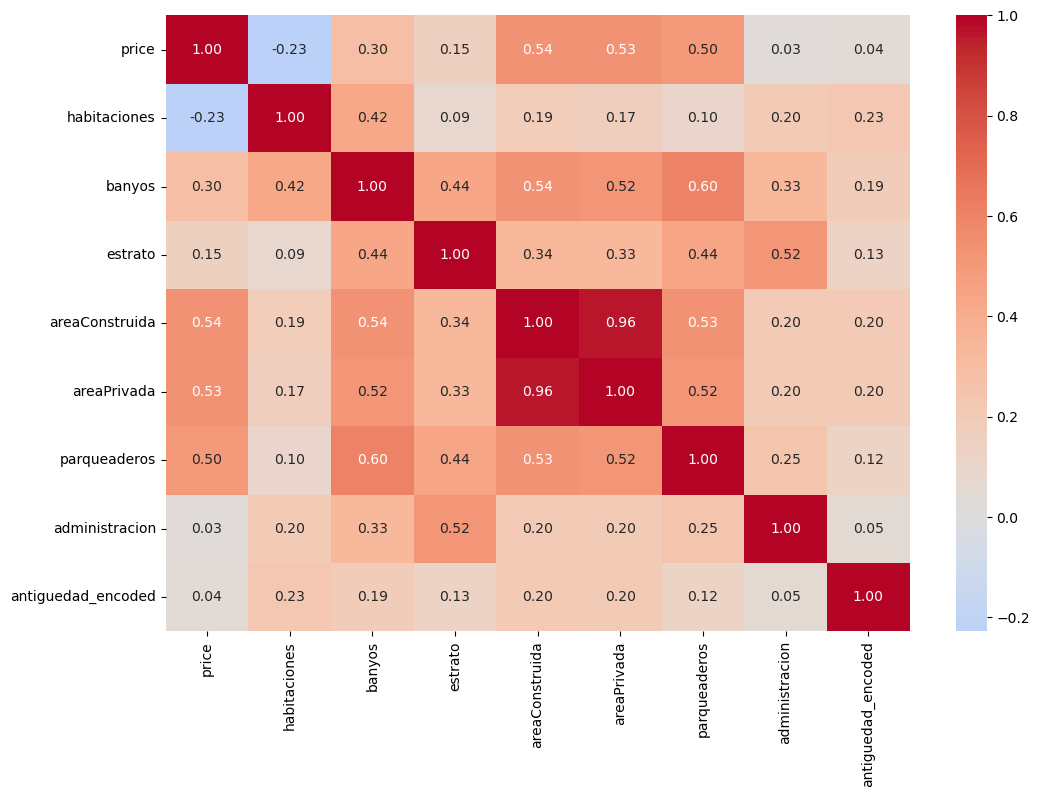

In [1014]:
new_main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","antiguedad_encoded"]
corr_matrix(df_encoded[new_main_columns])

## Visualización exploratoria de las variables

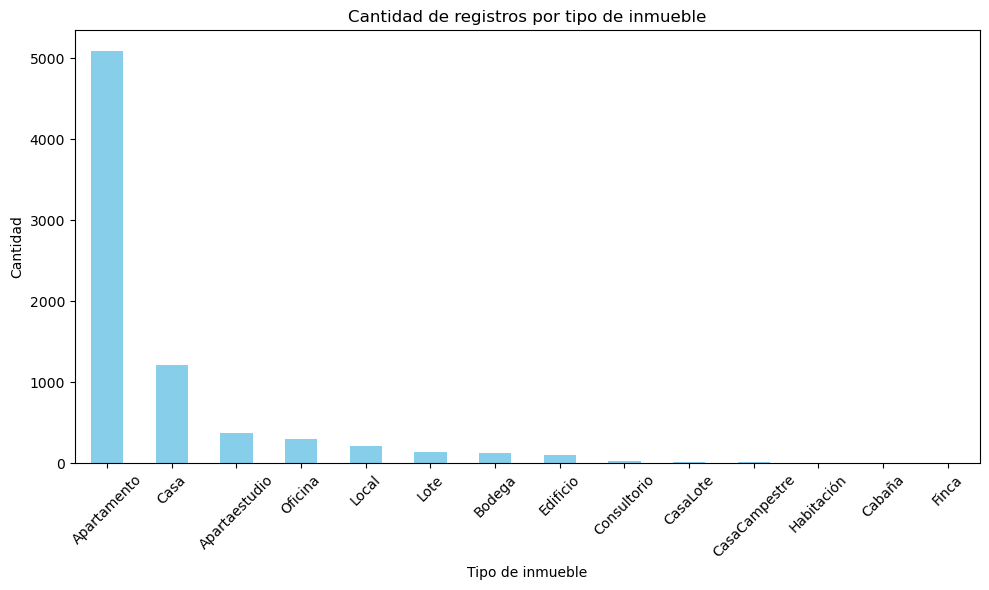

In [1044]:
import matplotlib.pyplot as plt
conteo = df_no_outliers["tipoInmueble"].value_counts()
conteo.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Cantidad de registros por tipo de inmueble")
plt.xlabel("Tipo de inmueble")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

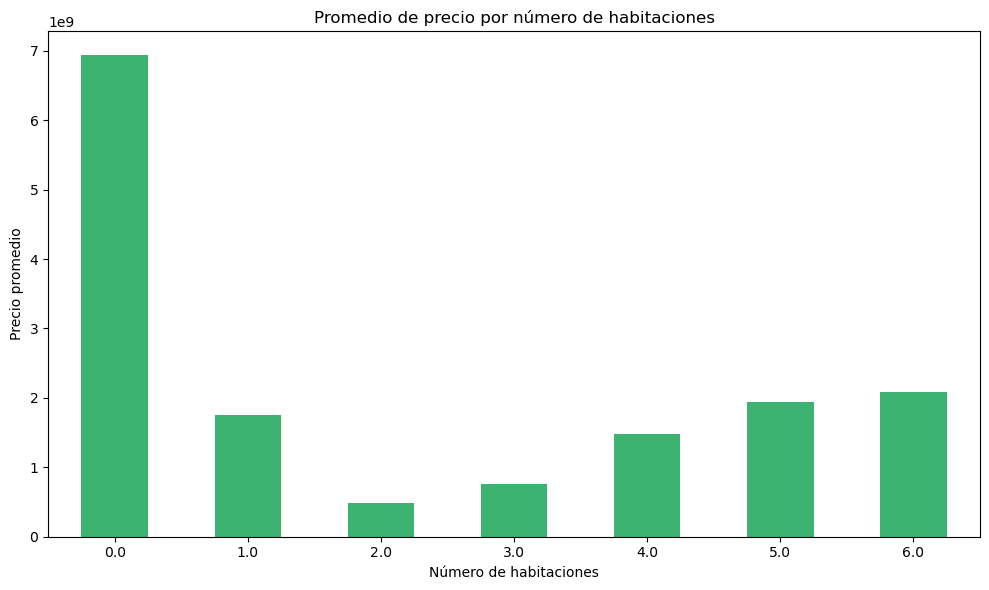

In [1045]:
import matplotlib.pyplot as plt
promedio_por_habitaciones = df_no_outliers.groupby("habitaciones")["price"].mean().sort_index()
promedio_por_habitaciones.plot(kind="bar", figsize=(10, 6), color="mediumseagreen")
plt.title("Promedio de precio por número de habitaciones")
plt.xlabel("Número de habitaciones")
plt.ylabel("Precio promedio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

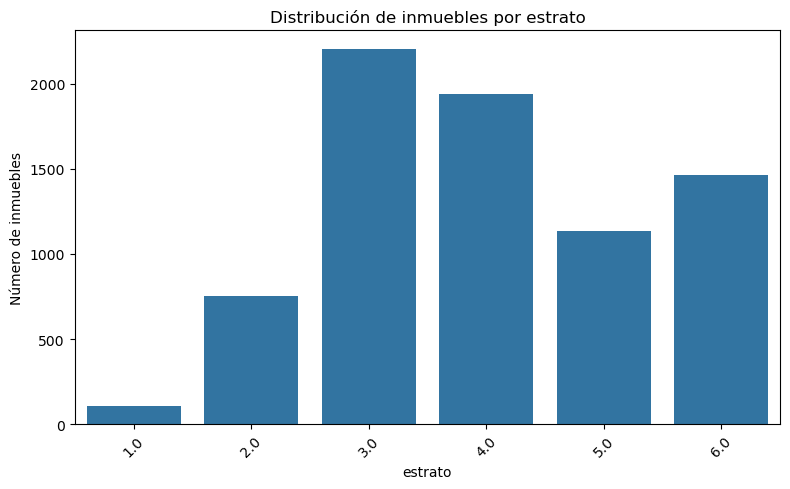

In [1015]:
# Suponiendo que tu dataframe se llama df y tiene la columna 'estrato'
# Contar la cantidad de inmuebles por estrato
df_no_outliers = df_no_outliers.dropna()

def bar_plot(df_,variable):
    # Crear el barplot
    conteo_estrato = df_[variable].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=conteo_estrato.index, y=conteo_estrato.values)
    # Etiquetas y título
    plt.xlabel(variable)
    plt.ylabel('Número de inmuebles')
    plt.title(f'Distribución de inmuebles por {variable}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Mostrar gráfico
    plt.show()

bar_plot(df_no_outliers, "estrato")

En la Figura se presenta la distribución de inmuebles según el estrato socioeconómico. Se observa que la mayor concentración de inmuebles corresponde al estrato 3, seguido por los estratos 4 y 6. Esto refleja una predominancia de la oferta inmobiliaria en estratos medios, lo cual es consistente con la estructura socioeconómica y la dinámica urbana de Bogotá. Por otro lado, los inmuebles de estrato 1 representan una proporción significativamente menor dentro de la muestra analizada.

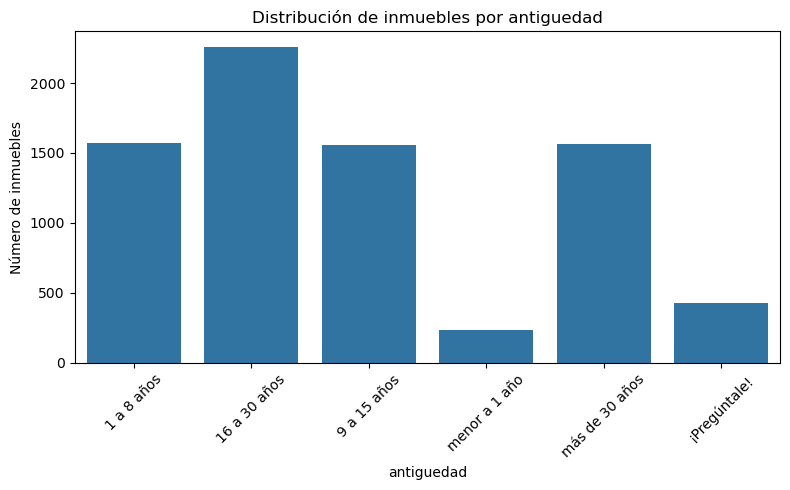

In [1016]:
bar_plot(df_no_outliers, "antiguedad")

* En la Figura se presenta la distribución de inmuebles según su antigüedad. Se observa que la mayoría de los inmuebles tienen entre 16 y 30 años de construcción, seguidos por aquellos con más de 30 años y por inmuebles de entre 9 a 15 años. Este comportamiento es coherente con el desarrollo urbano de Bogotá, donde muchas edificaciones fueron construidas durante el auge de crecimiento inmobiliario de finales del siglo XX y principios del XXI.* 
También se evidencia que las viviendas de menos de 1 año representan una proporción pequeña, indicando una menor cantidad de proyectos recientes en la muestra recopilada. Por otro lado, una cantidad significativa de registros contiene la etiqueta ¡Pregúntale!, la cual se identifica como un placeholder, lo que revela que la antigüedad de algunos inmuebles no fue diligenciada en la fuente de datos.


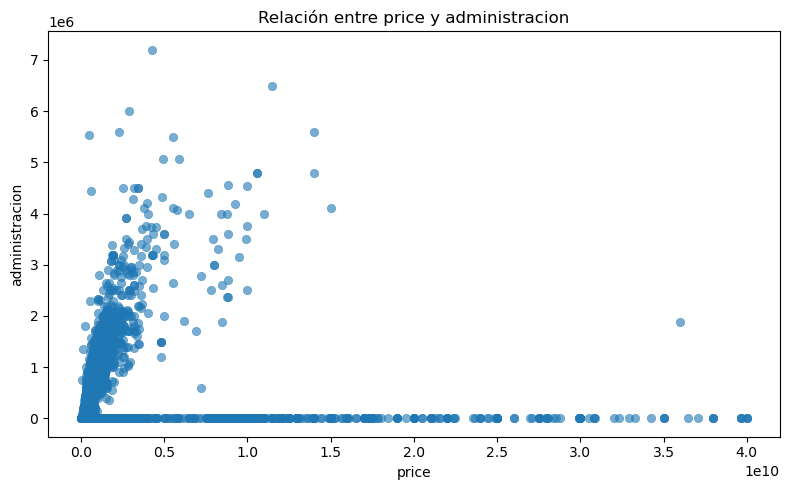

In [1017]:
def scatter_plot(df, col_x, col_y):
    """
    Genera un scatter plot entre dos columnas de un dataframe.

    Parámetros:
    - df: dataframe que contiene los datos
    - col_x: nombre de la columna para el eje X (string)
    - col_y: nombre de la columna para el eje Y (string)
    """
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=col_x, y=col_y, alpha=0.6, edgecolor=None)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f"Relación entre {col_x} y {col_y}")
    plt.tight_layout()
    plt.show()

scatter_plot(df_no_outliers,"price","administracion")


* En la Figura se observa la relación entre el precio de los inmuebles y el valor de la cuota de administración. Se evidencia una relación positiva entre ambas variables, donde en general, inmuebles con precios más altos tienden a asociarse con cuotas de administración más elevadas. No obstante, la dispersión es significativa, especialmente en rangos intermedios, lo que sugiere que inmuebles de precios similares pueden tener costos de administración muy variables, posiblemente debido a diferencias en servicios, ubicación o tipo de propiedad.* 
También se identifican algunos valores extremos, tanto en precios como en administración, que podrían representar inmuebles atípicos o errores de captura. Esta relación positiva es consistente con la correlación numérica previamente observada y respalda la hipótesis de que las características físicas y de servicios de los inmuebles inciden en su precio de venta


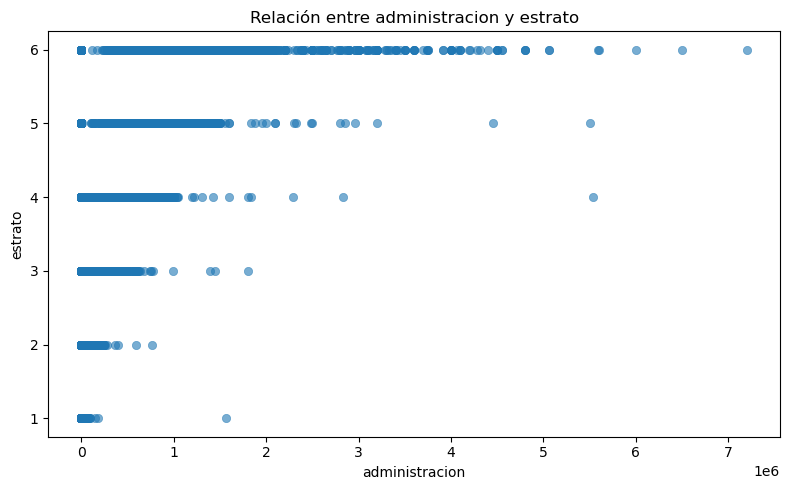

In [1018]:
scatter_plot(df_no_outliers,"administracion","estrato")

En la Figura se presenta la relación entre el valor de la cuota de administración y el estrato socioeconómico de los inmuebles. Se observa una clara tendencia en la que los inmuebles de estratos altos (especialmente 5 y 6) concentran las cuotas de administración más elevadas, mientras que en los estratos bajos (1 y 2) las cuotas de administración son considerablemente menores. Esta relación es consistente con las dinámicas típicas del mercado inmobiliario de Bogotá, donde las propiedades de estratos superiores suelen ofrecer más y mejores servicios comunales, lo que incrementa los costos asociados. 
No obstante, también se identifican algunos valores atípicos, como inmuebles de estratos bajos con cuotas de administración elevadas, lo que podría atribuirse a errores de registro o casos excepcionales como edificaciones con servicios premium ubicadas en sectores tradicionales. Esta visualización refuerza la correlación positiva previamente identificada entre estrato y administracion


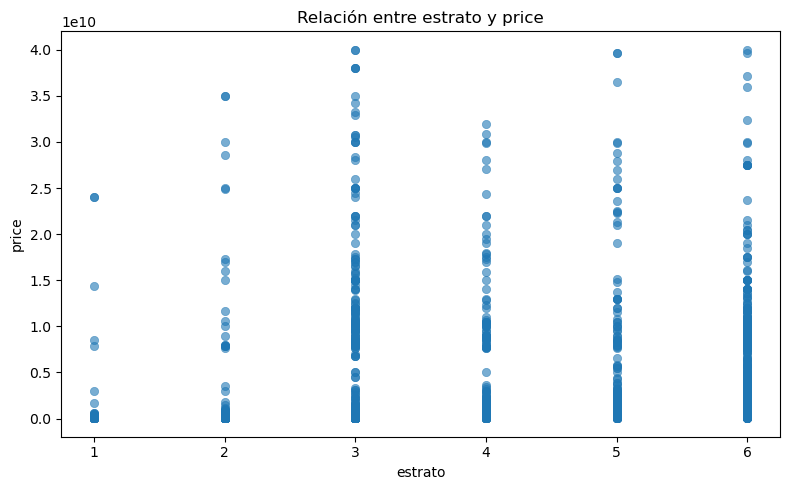

In [1019]:
scatter_plot(df_no_outliers,"estrato","price")

En la Figura se muestra la relación entre el estrato socioeconómico y el precio de los inmuebles. Si bien podría esperarse una relación creciente entre ambos, la gráfica revela que no existe una asociación fuerte o lineal entre estrato y precio. Se observa una alta dispersión de precios en todos los estratos, incluyendo inmuebles de precios elevados incluso en estratos medios (3 y 4), lo que sugiere que el estrato por sí solo no es un factor determinante del precio.
Este comportamiento es consistente con la dinámica inmobiliaria de Bogotá, donde existen zonas de estrato medio con inmuebles de alto valor debido a su ubicación estratégica, tipo de inmueble o características particulares. Asimismo, en estratos altos es posible encontrar inmuebles de menor precio debido a factores como tamaño, estado de conservación o antigüedad. Esta visualización refuerza lo observado en la matriz de correlación, donde la relación entre estrato y precio resultó ser baja


## modelo de machine learning para predecir precio

In [1020]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


def linear_regression(df_):
    # 🎯 1. Define features (X) and target (y)
    numeric_cols = df_.select_dtypes(include=["int64", "float64"]).columns
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # ✂️ 2. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # 🤖 4. Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # 📈 5. Predict and evaluate
    y_pred = model.predict(X_test)
    # y_pred_rounded = np.round(y_pred).astype(np.int64)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
    print("R^2 Score:", r2_score(y_test, y_pred))
    return X_train, X_test, y_train, y_test, y_pred

X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled)

Mean Absolute Error (MAE): 549710919.0249054
Root Mean Squared Error (RMSE): 5643682400.3995495
R^2 Score: -3.094396560164173e+21


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1021]:
import pandas as pd

# Crear un DataFrame con reales y predicciones
comparacion = pd.DataFrame({
    "valor_real": y_test.values,
    "prediccion": y_pred
})

# Mostrar 10 muestras aleatorias
print(comparacion.sample(20, random_state=42))

      valor_real      prediccion
566         0.00           -0.01
1101        0.02            0.01
1473        0.02            0.01
1177        0.01            0.02
1009        0.04            0.06
433         0.23            0.45
855         0.02            0.02
1491        0.02            0.09
1032        0.03            0.04
1079        0.01           -0.02
1382        0.01           -0.00
782         0.04            0.21
1085        0.01           -0.00
1138        0.01 -62844601889.08
986         0.00           -0.17
923         0.00            0.05
332         0.01            0.00
909         0.01            0.01
757         0.00            0.01
1233        0.00            0.01


In [1022]:
df_scaled_no_comodidades = df_scaled.copy()
print(f"total columns before removing commodities is: {df_scaled_no_comodidades.shape[1]}")
for col in df_comodidades.columns:
    if col in df_scaled_no_comodidades.columns:
        #print(f"col {col} will be deleted")
        df_scaled_no_comodidades = df_scaled_no_comodidades.drop(columns=[col])
df_scaled_no_comodidades = df_scaled_no_comodidades.loc[:, ~df_scaled_no_comodidades.columns.str.startswith("ubicacion_")]
print(f"total columns after removing commodities is: {df_scaled_no_comodidades.shape[1]}")
X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled_no_comodidades)

total columns before removing commodities is: 1029
total columns after removing commodities is: 29
Mean Absolute Error (MAE): 0.024728363112679508
Root Mean Squared Error (RMSE): 0.07020054357453392
R^2 Score: 0.5212246437973331


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1023]:
X_train, X_test, y_train, y_test, y_pred = linear_regression(df_scaled[new_main_columns])

Mean Absolute Error (MAE): 0.03024779077287699
Root Mean Squared Error (RMSE): 0.07569503870650363
R^2 Score: 0.4433455709234154


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1024]:
#X_train['Área Urbana'].unique()

In [1025]:
# # Combine features and predictions
# comparacion_completa = X_test.copy()
# comparacion_completa["valor_real"] = y_test.values
# comparacion_completa["prediccion"] = y_pred  # or y_pred_rounded if you prefer
# comparacion_completa["error"] = abs(comparacion_completa["valor_real"] - comparacion_completa["prediccion"])

# # Save to CSV
# comparacion_completa.to_csv("predicciones_completas_sin_comodidades.csv", index=False)

In [1026]:
# # Combine features and predictions
# comparacion_completa = X_test.copy()
# comparacion_completa["valor_real"] = y_test.values
# comparacion_completa["prediccion"] = y_pred  # or y_pred_rounded if you prefer
# comparacion_completa["error"] = abs(comparacion_completa["valor_real"] - comparacion_completa["prediccion"])

# # Save to CSV
# comparacion_completa.to_csv("predicciones_completas.csv", index=False)

In [1027]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def random_forest_regressor(df_):
    # Separar variables
    print(f"total columns are: {df_.shape[1]}")
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Modelo
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)
    # Predicción
    y_pred = rf_reg.predict(X_test)
    # Evaluación
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

random_forest_regressor(df_scaled)

total columns are: 1029
MAE: 0.0157
RMSE: 0.0661
R² Score: 0.5752


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1028]:
random_forest_regressor(df_scaled[new_main_columns])

total columns are: 9
MAE: 0.0162
RMSE: 0.0686
R² Score: 0.5426


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1029]:
random_forest_regressor(df_scaled_no_comodidades)

total columns are: 29
MAE: 0.0159
RMSE: 0.0658
R² Score: 0.5795


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1030]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_scaled_with_range_price = df_scaled.copy()
df_scaled_with_range_price["range_price"] = pd.qcut(df_scaled["price"], q=7, labels=False) + 1

if "price" in df_scaled_with_range_price.columns:
    df_scaled_with_range_price=df_scaled_with_range_price.drop(columns=["price"])
df_scaled_with_range_price["range_price"] = df_scaled_with_range_price["range_price"].astype(int)

new_range_price_columns=["range_price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos","antiguedad_encoded"]

# Separar variables
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predicción
y_pred = rf_clf.predict(X_test)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7120
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85       229
           2       0.69      0.77      0.73       201
           3       0.62      0.60      0.61       218
           4       0.58      0.58      0.58       204
           5       0.69      0.63      0.66       228
           6       0.68      0.72      0.70       210
           7       0.84      0.84      0.84       231

    accuracy                           0.71      1521
   macro avg       0.71      0.71      0.71      1521
weighted avg       0.71      0.71      0.71      1521

Confusion Matrix:
 [[192  32   2   0   1   0   2]
 [ 19 154  27   0   1   0   0]
 [  4  34 130  42   6   2   0]
 [  3   2  44 119  32   2   2]
 [  1   0   7  40 144  33   3]
 [  0   0   0   4  24 151  31]
 [  4   0   0   0   0  34 193]]


In [1031]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def gradient_boost_regressor(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # Suponiendo precio real
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_reg.fit(X_train, y_train)
    y_pred = gb_reg.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

gradient_boost_regressor(df_scaled)

MAE: 0.0184
RMSE: 0.0673
R² Score: 0.5597


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1032]:
gradient_boost_regressor(df_scaled[new_main_columns])

MAE: 0.0185
RMSE: 0.0707
R² Score: 0.5143


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1033]:
gradient_boost_regressor(df_scaled_no_comodidades)

MAE: 0.0176
RMSE: 0.0673
R² Score: 0.5605


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1034]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Asumiendo que ya tienes:
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"].astype(int)  # Asegúrate de que sean enteros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

# Predicción
y_pred = gb_clf.predict(X_test)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7041
Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.83      0.83       229
           2       0.64      0.69      0.67       201
           3       0.63      0.60      0.62       218
           4       0.59      0.61      0.60       204
           5       0.69      0.61      0.64       228
           6       0.68      0.73      0.71       210
           7       0.85      0.84      0.85       231

    accuracy                           0.70      1521
   macro avg       0.70      0.70      0.70      1521
weighted avg       0.70      0.70      0.70      1521

Confusion Matrix:
 [[190  32   2   1   1   1   2]
 [ 31 139  27   4   0   0   0]
 [  3  38 131  39   5   1   1]
 [  0   5  42 125  28   2   2]
 [  0   2   5  43 138  38   2]
 [  0   0   0   1  29 153  27]
 [  7   0   0   0   0  29 195]]


In [1035]:
from sklearn.tree import DecisionTreeClassifier
# Asumiendo que ya tienes:
X = df_scaled_with_range_price.drop(columns=["range_price"])
y = df_scaled_with_range_price["range_price"].astype(int)  # Asegúrate de que sean enteros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6088
Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.84      0.75       229
           2       0.67      0.48      0.56       201
           3       0.50      0.33      0.40       218
           4       0.46      0.66      0.55       204
           5       0.53      0.49      0.51       228
           6       0.60      0.68      0.64       210
           7       0.85      0.76      0.80       231

    accuracy                           0.61      1521
   macro avg       0.61      0.61      0.60      1521
weighted avg       0.62      0.61      0.60      1521

Confusion Matrix:
 [[193  14  12   1   5   1   3]
 [ 62  97  32   7   3   0   0]
 [ 23  27  72  78  16   2   0]
 [  3   6  22 135  33   5   0]
 [  1   0   2  68 112  43   2]
 [  0   0   0   2  40 142  26]
 [  6   0   3   0   3  44 175]]


In [1036]:
from sklearn.tree import DecisionTreeRegressor

def regression_tree_decision(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # No convertir a int si es continua

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
regression_tree_decision(df_scaled)

MAE: 0.0232
RMSE: 0.0714
R² Score: 0.5053


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1037]:
regression_tree_decision(df_scaled[new_main_columns])

MAE: 0.0206
RMSE: 0.0743
R² Score: 0.4636


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1038]:
regression_tree_decision(df_scaled_no_comodidades)

MAE: 0.0232
RMSE: 0.0722
R² Score: 0.4929


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1039]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mlp_regression(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicción
    y_pred = mlp.predict(X_test)

    # Evaluación
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

mlp_regression(df_scaled)

MAE: 0.0296
RMSE: 0.0729
R² Score: 0.4830


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1040]:
mlp_regression(df_scaled[new_main_columns])

MAE: 0.0203
RMSE: 0.0690
R² Score: 0.5372


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1041]:
mlp_regression(df_scaled_no_comodidades)

MAE: 0.0210
RMSE: 0.0679
R² Score: 0.5517


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1042]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def mlp_classification(df_):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)  # Asegúrate de que sean clases enteras

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicción
    y_pred = mlp.predict(X_test)

    # Evaluación
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mlp_classification(df_scaled_with_range_price)

Accuracy: 0.6581
Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.79      0.79       229
           2       0.65      0.66      0.65       201
           3       0.61      0.52      0.56       218
           4       0.51      0.60      0.55       204
           5       0.60      0.54      0.57       228
           6       0.63      0.65      0.64       210
           7       0.81      0.83      0.82       231

    accuracy                           0.66      1521
   macro avg       0.66      0.66      0.65      1521
weighted avg       0.66      0.66      0.66      1521

Confusion Matrix:
 [[181  34   8   1   1   0   4]
 [ 35 132  28   5   1   0   0]
 [  5  31 114  58   6   4   0]
 [  3   7  29 122  41   2   0]
 [  1   0   7  49 124  44   3]
 [  0   0   0   2  33 137  38]
 [  6   0   1   1   1  31 191]]


In [1043]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def knn_classification(df_, n_neighbors=5):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)

    # Normalizar (obligatorio para KNN)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predicción
    y_pred = knn.predict(X_test)

    # Evaluación
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

knn_classification(df_scaled_with_range_price)

Accuracy: 0.4799
Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.74      0.70       229
           2       0.40      0.55      0.46       201
           3       0.34      0.35      0.35       218
           4       0.35      0.37      0.36       204
           5       0.39      0.36      0.37       228
           6       0.46      0.40      0.43       210
           7       0.84      0.58      0.69       231

    accuracy                           0.48      1521
   macro avg       0.49      0.48      0.48      1521
weighted avg       0.50      0.48      0.48      1521

Confusion Matrix:
 [[169  43   9   6   0   1   1]
 [ 41 110  34   8   6   2   0]
 [ 14  71  77  38  14   4   0]
 [  5  31  51  75  30  11   1]
 [  5  11  43  49  81  34   5]
 [  7   8   9  30  54  84  18]
 [ 13   2   5   9  23  45 134]]
